In [1]:
import pymania as mn
import pylab as plt
from collections import Counter

In [2]:
a = mn.io.get_roi_regressor('L1')

In [3]:
mn.ST.load_roi_regressors()

In [4]:
a = mn.ST(126426,'L1','L11')
a.load_mania_results()

In [5]:
a.isConnected()

False

In [6]:
a.load_mania_results()

In [7]:
a.process()

MANIA2Error: Connection is null

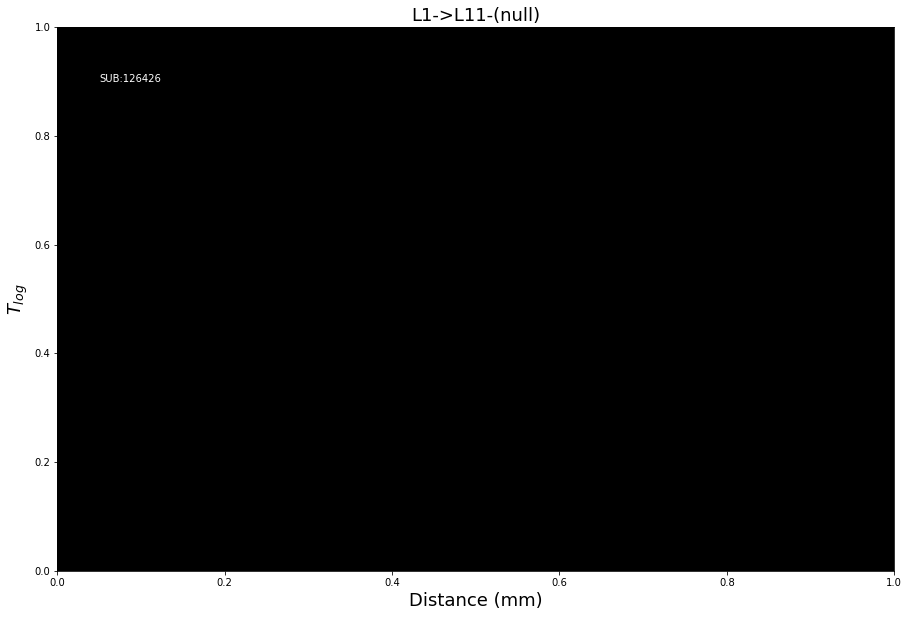

In [8]:
a.plot()

In [9]:
from py2neo import Node, Relationship, Graph
import numpy

graph = Graph(host="canopus.cc.gatech.edu",password='1234')

In [10]:
subs = [126426, 137431, 144125, 146735, 152427, 153227, 177140, 180533, 186545, 135124]

In [11]:
query = '''MATCH (n:ROI)-[r:MANIA2]->(m:ROI)
WHERE r.SUBJECT IN [126426, 137431, 144125, 146735, 152427, 153227, 177140, 180533, 186545, 135124] AND n.name STARTS WITH 'L' AND r.is_connected=TRUE
WITH n.name AS source, m.name AS target, r.SUBJECT AS subject, r.correction_type as correction_type
WITH source, target, COUNT(*) AS connections, COLLECT(subject) AS subjects, COLLECT(correction_type) as correction_types WHERE connections=5
RETURN source, target, subjects, correction_types order by source, target'''
A1 = graph.run(query).data()

In [12]:
query = '''MATCH (n:ROI)-[r:MANIA2]->(m:ROI)
WHERE r.SUBJECT IN [126426, 137431, 144125, 146735, 152427, 153227, 177140, 180533, 186545, 135124] AND n.name STARTS WITH 'L' AND r.is_connected=False
WITH n.name AS source, m.name AS target, r.SUBJECT AS subject, r.correction_type as correction_type
WITH source, target, COUNT(*) AS connections, COLLECT(subject) AS subjects, COLLECT(correction_type) as correction_types WHERE connections=5
RETURN source, target, subjects, correction_types order by source,target'''
A2 = graph.run(query).data()

In [13]:
l = len(A1)
D = {}
for i in range(l):
    rec1 = A1[i]
    rec2 = A2[i]
    r1 = rec1['source']
    r2 = rec1['target']
    if (r1 != rec2['source'] or r2 != rec2['target']):
        print('wrong data')
    tmp1 = rec1['correction_types'] + rec2['correction_types']
    tmp2 = Counter(tmp1)
    a = tmp2.most_common(1)[0]
    D[(r1,r2)] = a[0]

In [14]:
# pick 5 fallback, 3 envelope and 2 null
import random
t = list(D.keys())
random.shuffle(t)

In [15]:
f = 0
n = 0
e = 0
C = []
for w in t:
    if D[w] == 'fallback' and f<5:
        C.append(w)
        f = f + 1
    if D[w] == 'null' and n<2:
        C.append(w)
        n = n + 1
    if D[w] == 'envelope' and e<3:
        C.append(w)
        e = e + 1

/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


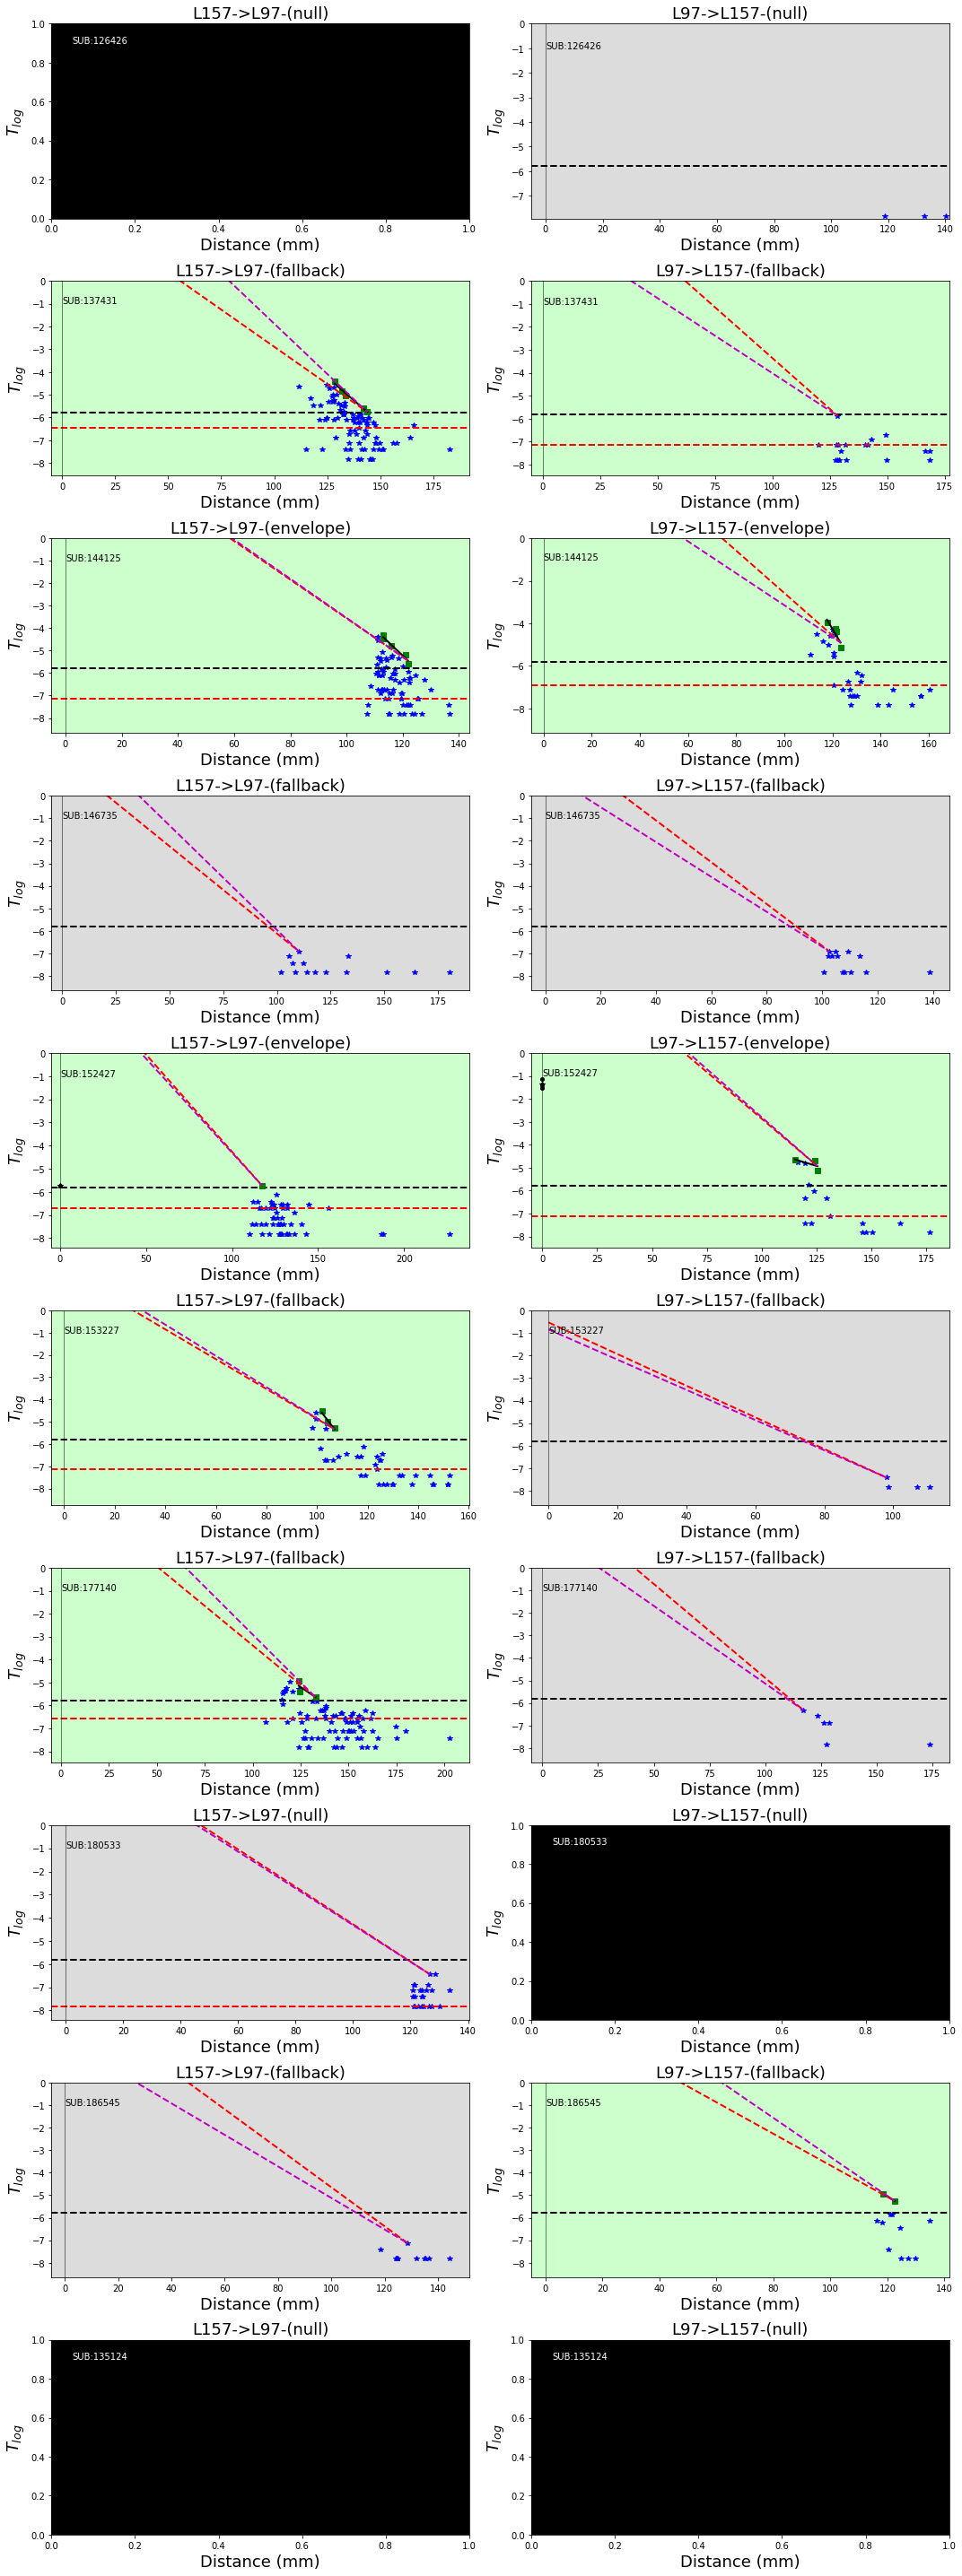

In [19]:
c = 2 # connection num
fig, ax  = plt.subplots(10,2,figsize=(15,40))
for i,sub in enumerate(subs):
    a = mn.ST(subs[i],C[c][0],C[c][1])
    b = mn.ST(subs[i],C[c][1],C[c][0])
    a.load_mania_results()
    b.load_mania_results()
    try:
        a.process()
        b.process()
    except:
        pass
    p = mn.PairST(a,b)
    p.plot(ax[i,:])

plt.tight_layout()

In [14]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [17]:
mn.EnsembleST(144125)

pymania.base.EnsembleST

In [22]:
sub = mn.compute_subject(144125, save=False)

Pre:   0%|          | 0/32220 [00:00<?, ?it/s]/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Pre:   0%|          | 5/32220 [00:00<13:22, 40.15it/s]

Preprocessing connections for subject144125


 27%|██▋       | 48/180 [00:00<00:00, 243.01it/s]

Find roi regressors for subject144125


100%|██████████| 180/180 [00:00<00:00, 229.00it/s]


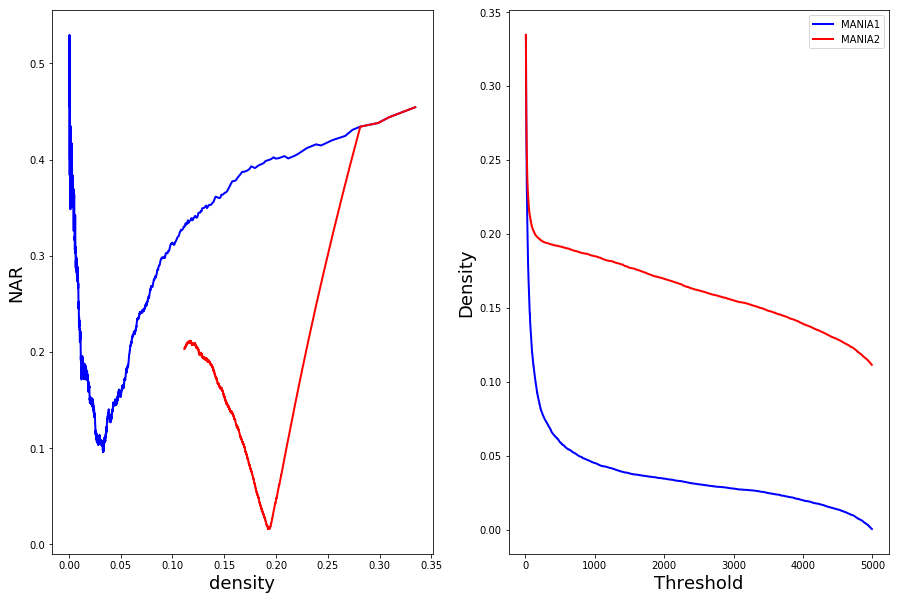

In [23]:
sub.plot_mania()

In [25]:
net,den,nar,t = mn.mania_on_mat(sub.matrix2)

In [28]:
import matplotlib.pyplot as pl

In [40]:
mn.density(net)

0.3345127250155183

In [33]:
import numpy as np

In [35]:
np.argmin(nar)

397

In [36]:
t[397]

408

In [37]:
np.log(408/5000)

-2.505926017012076

In [74]:
nn = np.zeros((180,180))
nn[sub.matrix2>4990]=1

In [75]:
print(mn.density(nn),mn.NAR(nn))


0.11145251396648044 0.20277211594076533


In [65]:
np.exp(-5.8)*5000

15.137773726879077

In [87]:
def mania_on_mat(B,nos = 5000,cut = 10, log=False):
	l = nos-2*cut
	den = [0.0]*l
	nar = [0.0]*l
	t = [0.0]*l
	n,_ = B.shape
	his = float('inf')
	C = np.zeros((n,n))
	for i in range(nos-cut,cut,-1):
		if log:
			th = np.log(i/nos)
		else:
			th = i
		t[i-cut-1] = th
		C[B>=th] = 1
		den[i-cut-1] = mn.density(C)
		tmp = mn.NAR(C)
		nar[i-cut-1] = tmp
	ind = np.argmin(nar)
	t = t[ind]
	net = np.zeros((n,n))
	net[B>=t] = 1
	return (net,den,nar,t)

In [88]:
net,den,nar,t = mania_on_mat(sub.matrix2)

In [89]:
np.argmin(nar)

397

In [90]:
den[397]

0.19252017380509

In [91]:
mn.density(net)

0.19252017380509